In [143]:
import numpy as np                        # базовые модули
import matplotlib.pyplot as plt
import pandas as pd 
import scipy.stats as stats

import nltk                               # для обработки текстов 
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from string import punctuation

from datetime import datetime 

from PIL import Image                     # для облака слов
from wordcloud import WordCloud

import warnings
warnings.filterwarnings("ignore")

In [172]:
def datetimer(string):                    # чтобы даты в нормальный вид приводить
    date = string.split('-')
    day = int(date[2])
    year = int(date[0])
    month = int(date[1])
    date = datetime(year, month, day)
    return date

### В этой тетрадке мы смотрим на имеющиеся данные

Сначала посмотрим на лемматизированные посты

In [144]:
data_no_stopwords = pd.read_csv('https://raw.githubusercontent.com/Pash1i/andan_2023_project/updates/data/lemmatized_no_noise.csv').drop('Unnamed: 0', axis = 1)

In [175]:
data_no_stopwords.date = data_no_stopwords.date.apply(datetimer)

In [145]:
data_no_stopwords.sample(3)

,author,date,n_likes,n_reposts,with_photo,is_repost?,text
6682,dying,2015-02-24,1178,7,False,False,обменять жир бухнуть
4334,dying,2015-04-30,2638,27,False,False,хватить ждать сообщение спать
1674,dying,2015-07-08,1121,9,False,False,улыбка влюбляться уставать грусть


In [146]:
#создадим общий набор слов
super_text = ' '.join(list(map(str, data_no_stopwords['text'])))

Давайте проверим, вдруг в инфантильном подростково-сопливом паблике самым часто встречающимся словом будет __*любить*__, было бы мило🥰🥰

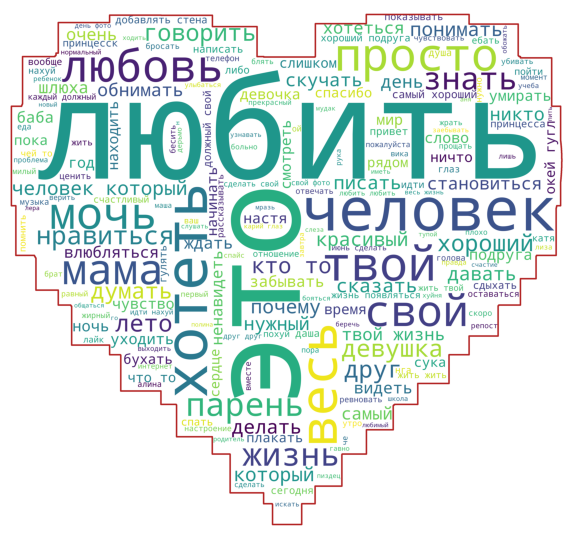

In [240]:
mask = np.array(Image.open('Сердечко.png'))
cloud = WordCloud(width=1000, height=1000, mask = mask,
                  contour_width=20, contour_color='firebrick', 
                  background_color='white', random_state= 765).generate(super_text)

plt.figure(figsize=(10, 10))
plt.imshow(cloud)
plt.axis('off')
plt.show()

Действительно, кажется, что слово __*любить*__ встречается в постах чаще всего. Посмотрим на другие популярные слова

In [148]:
words, counts = list(map(list, np.unique(super_text.split(), return_counts= True))) 

word_counter = []
for i, j in zip(words, counts):
    word_counter.append([i, j])

In [149]:
most_10 = dict(sorted(word_counter, key = lambda x: x[1], reverse=True)[:10])

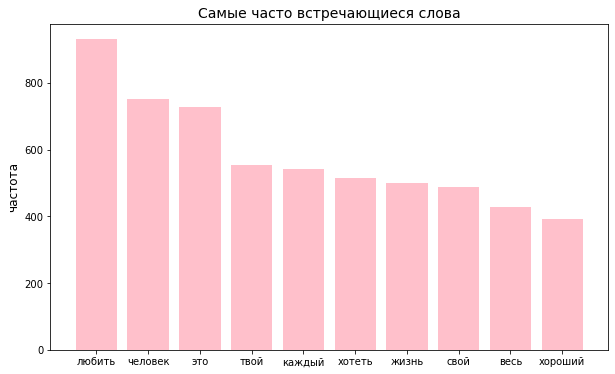

In [150]:
plt.figure(figsize=(10, 6))
plt.bar(most_10.keys(), height=most_10.values(), color = 'pink')
plt.ylabel('частота', fontsize = 12)
plt.title('Самые часто встречающиеся слова', fontsize = 14);

Интересно, почему авторы сообщества dying так часто используют в своих постах слово __*любить*__? Может такие посты набирают больше лайков? Проверим это формально.

In [151]:
def is_loved(string: str):
    string = str(string)
    if 'любить' in string:
        return 1
    else: 
        return 0 

In [152]:
data_no_stopwords['with_love'] = data_no_stopwords.text.apply(is_loved)

loved = data_no_stopwords[data_no_stopwords['with_love'] == 1]
not_loved = data_no_stopwords[data_no_stopwords['with_love'] == 0]

Проверим гипотезу о том, что посты со словом __*любить*__ в среднем набирают больше лайков.

$$
H_0: \mu_{loved} = \mu_{not\_loved}\\
$$
$$
H_1: \mu_{loved} > \mu_{not\_loved}
$$

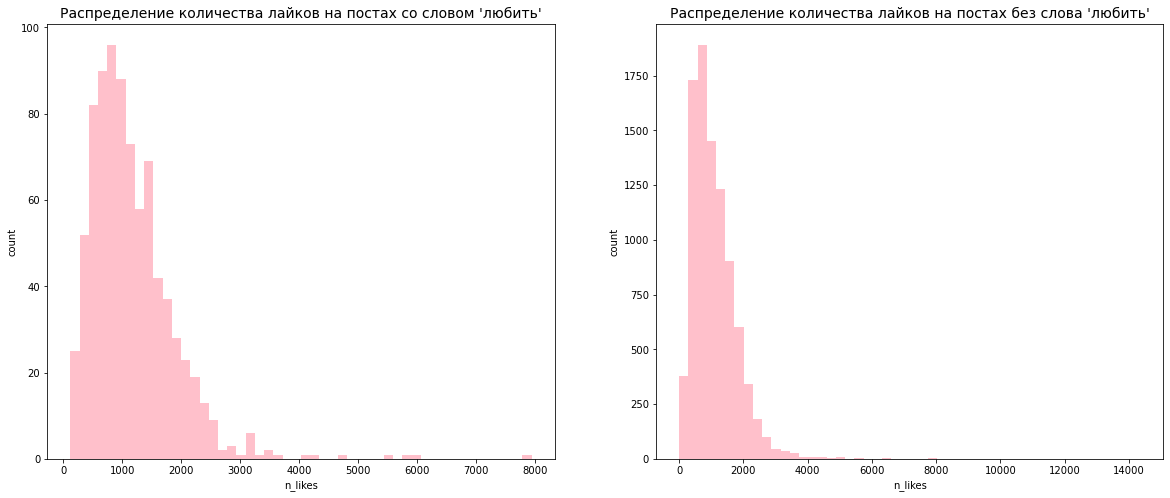

In [153]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize = (20, 8))

ax[0].hist(loved.n_likes, bins = 50, color = 'pink')
ax[0].set_xlabel('n_likes')
ax[0].set_ylabel('count')
ax[0].set_title("Распределение количества лайков на постах со словом 'любить'" , fontsize = 14)

ax[1].hist(not_loved.n_likes, bins = 50, color = 'pink')
ax[1].set_xlabel('n_likes')
ax[1].set_ylabel('count')
ax[1].set_title("Распределение количества лайков на постах без слова 'любить'" , fontsize = 14);

Среднее количество лайков будет асимптотически нормальным (по ЦПТ), дисперсии количества лайков в каждой группе мы не знаем, поэтому для проверки гипотезы будем использовать тест Уэлчаё

In [154]:
stats.ttest_ind(loved.n_likes, not_loved.n_likes, equal_var= False, alternative= 'greater')

Ttest_indResult(statistic=2.5453997328112554, pvalue=0.005533439306832869)

Полученное p-значение меньше, чем наиболее часто используемые уровни значимости. Нулевая гипотеза отвергается на уровне значимости 0.01, значит мы можем говорить, что посты со словом __*любить*__ в среднем __набирают больше лайков__.

Мы также проверям робастность результатов, заменяя количество лайков на количество репостов. Интуитивно, количество репостов, также как и количество лайков отражает отношение пользователей к посту. Обычно, чем больше лайков репостов, тем больше людей, считают текст в посте отражающим их настроение, значимым для них.

In [155]:
stats.ttest_ind(loved.n_reposts, not_loved.n_reposts, equal_var= False, alternative= 'greater')

Ttest_indResult(statistic=6.3989634170860015, pvalue=1.2021955478567185e-10)

С количеством репостов получили аналогичный результат: Подписчики в среднем больше репостят посты со словом __*любить*__, что может говорить о том, что слово любить в посте приносит постам (и, следовательно группе) большую популярность.

### Теперь посмотрим на маты

Можно предположить, что в группе, где подписчики больше лайкают посты со словом __*любить*__ нет места для негатива и брани. Мы решили изучить этот вопрос, воспользовавшись большим набором матерных слов на русском языке. 

In [156]:
with open('маты.txt', 'r', encoding='utf-8') as file:
    bad_words = set(map(lambda x: x.lower(), file.read().split('\n'))) 

In [157]:
def with_bad_words(string: str):
    words = set(str(string).split())

    if words & bad_words != set():
        return 1
    else:
        return 0

In [158]:
data_no_stopwords['with_bad_words'] = data_no_stopwords.text.apply(with_bad_words)

explicit = data_no_stopwords[data_no_stopwords['with_bad_words'] == 1]
no_explicit = data_no_stopwords[data_no_stopwords['with_bad_words'] == 0]

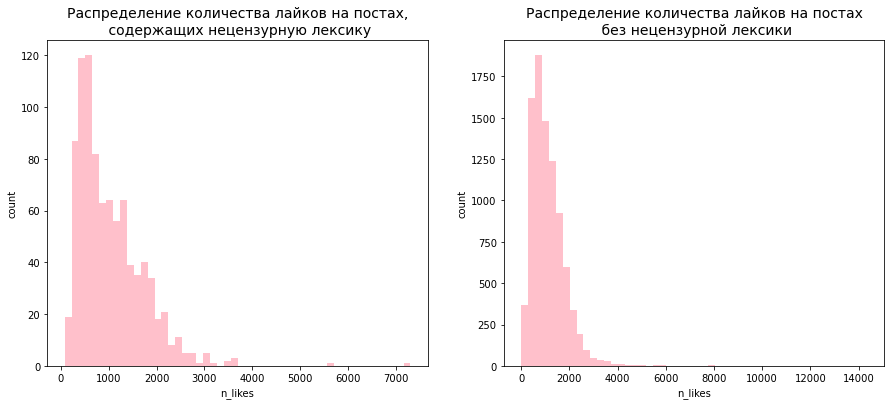

In [159]:
fig, ax = plt.subplots(nrows = 1, ncols=2, figsize = (15, 6))

ax[0].hist(explicit.n_likes, bins = 50, color = 'pink')
ax[0].set_xlabel('n_likes')
ax[0].set_ylabel('count')
ax[0].set_title("Распределение количества лайков на постах,\n содержащих нецензурную лексику" , fontsize = 14)

ax[1].hist(no_explicit.n_likes, bins = 50, color = 'pink')
ax[1].set_xlabel('n_likes')
ax[1].set_ylabel('count')
ax[1].set_title("Распределение количества лайков на постах\n без нецензурной лексики" , fontsize = 14);

Судя по выборочным средним, посты, содержащие нецензурную лексику в среднем по выборке набирали меньше лайков, чем посты без такой лексики

In [160]:
explicit.n_likes.mean(), no_explicit.n_likes.mean()

(1027.4424778761063, 1114.1551937113982)

Однако, так ли это на самом деле. Мы статистически проверям гипотезу, о том, что посты с матерными словами в среднем набирают меньше лайков

$$
H_0: \mu_{explicit} = \mu_{no\_explicit}\\
$$
$$
H_1: \mu_{explicit} < \mu_{no\_explicit}
$$

Опять же, мы используем тест Уэлча, так как дисперсии неизвестны.

In [161]:
stats.ttest_ind(explicit.n_likes, no_explicit.n_likes, equal_var= False, alternative= 'less')

Ttest_indResult(statistic=-3.5544903220612625, pvalue=0.00019722443657172926)

Полученное p-значение меньше 0.01, а значит нулевая гипотеза отвергается на уровне значимости 0.1%. Можно довольно уверенно говорить о том, что подписчики группы dying не любят посты с нецензурной лексикой!

### Достанем объединенную табличку с погодой и постами

In [198]:
data_weather_12 = pd.read_csv('https://raw.githubusercontent.com/Pash1i/andan_2023_project/updates/data/data_weather/data_weather_12.csv').drop('Unnamed: 0', axis = 1).dropna()

In [199]:
data_weather_12.date

0       2015-08-17
1       2015-08-17
2       2015-08-17
3       2015-08-17
4       2015-08-17
           ...    
9804    2014-10-30
9805    2014-10-30
9806    2014-10-30
9807    2014-10-30
9808    2014-10-30
Name: date, Length: 9703, dtype: object

In [200]:
data_weather_12.date = data_weather_12.date.apply(datetimer)

Посмотрим, сколько в среднем лайков и репостов набирали посты, опубликованные в один день

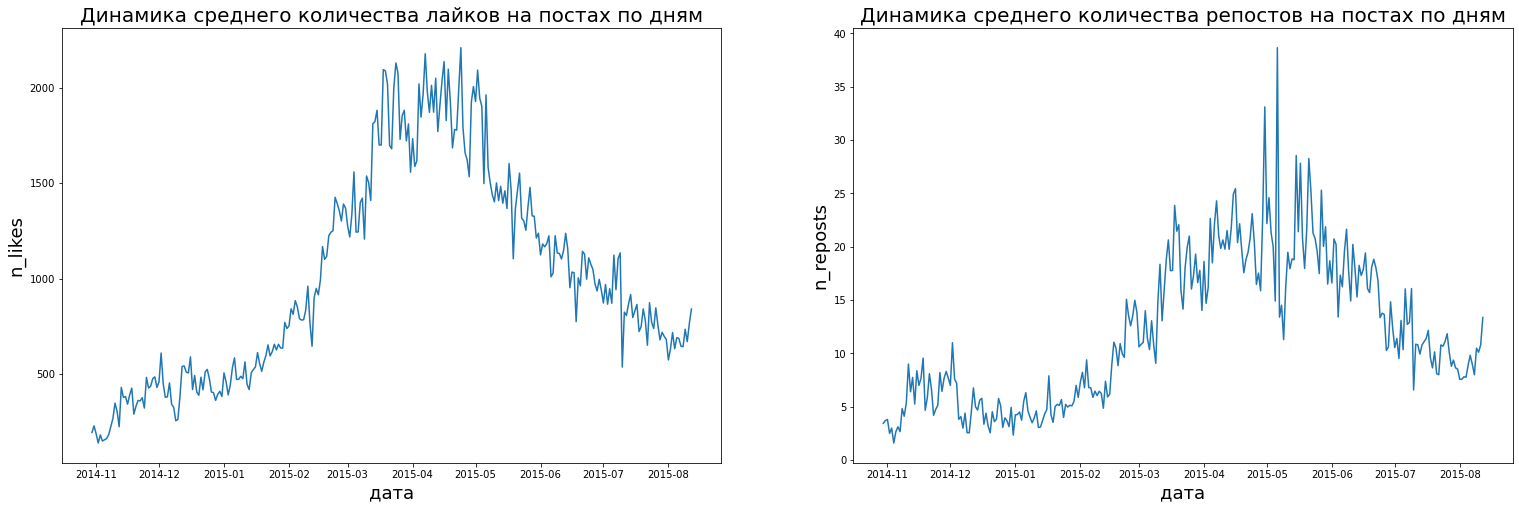

In [215]:
fig, ax = plt.subplots(ncols = 2,figsize = (26,8))

ax[0].plot(data_no_stopwords.groupby(by = 'date').n_likes.mean().index[:287], data_no_stopwords.groupby(by = 'date').n_likes.mean().values[:287])
ax[0].set_xlabel('дата', fontsize = 18)
ax[0].set_ylabel('n_likes', fontsize = 18)
ax[0].set_title('Динамика среднего количества лайков на постах по дням', fontsize = 20); 

ax[1].plot(data_no_stopwords.groupby(by = 'date').n_reposts.mean().index[:287], data_no_stopwords.groupby(by = 'date').n_reposts.mean().values[:287])
ax[1].set_xlabel('дата', fontsize = 18)
ax[1].set_ylabel('n_reposts', fontsize = 18)
ax[1].set_title('Динамика среднего количества репостов на постах по дням', fontsize = 20);

Я убрал последние несколько дней, так как из-за того, что паблик не активен с августа 2015-года, последние опубликованные посты набрали за 8 лет очень много лайков и, по-факту, являются выбросом и мешают анализу 

А что с погодой?

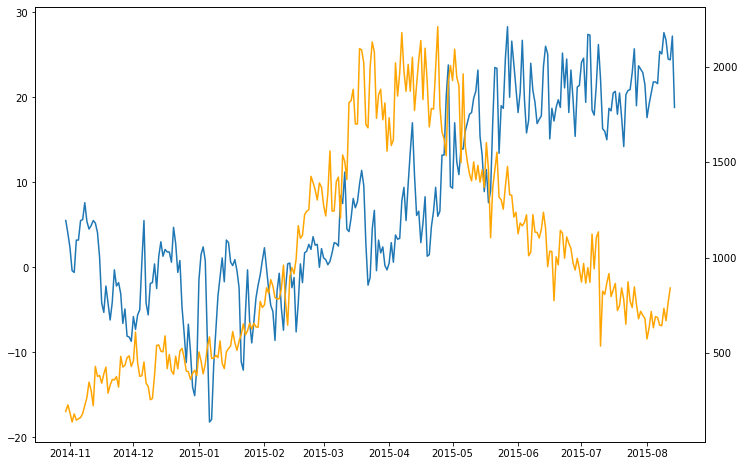

In [228]:
fig,ax1 = plt.subplots(figsize = (12,8))
ax1.plot(data_weather_12.groupby('date').mean()['T'].index[:287], data_weather_12.groupby('date').mean()['T'].values[:287])

ax2 = ax1.twinx()
ax2.plot(data_no_stopwords.groupby(by = 'date').n_likes.mean().index[:287], data_no_stopwords.groupby(by = 'date').n_likes.mean().values[:287], color = 'orange')

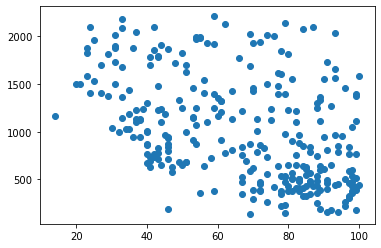

In [238]:
plt.scatter(data_weather_12.groupby('date').mean()['U'].values[:287], data_no_stopwords.groupby(by = 'date').n_likes.mean().values[:287]);

In [230]:
data_weather_12

,author,date,n_likes,n_reposts,with_photo,is_repost?,text,T,Po,U,DD,Ff,N,VV,Td
0,dying,2015-08-17,14351,325,False,False,хотеть видеть каждый день,14.0,749.5,64.0,"Ветер, дующий с севера",3.0,7.0,10.0,7.3
1,dying,2015-08-17,7098,144,False,False,жить жить твой жизнь появляться полина,14.0,749.5,64.0,"Ветер, дующий с севера",3.0,7.0,10.0,7.3
2,dying,2015-08-17,6439,121,False,False,скучать наташа,14.0,749.5,64.0,"Ветер, дующий с севера",3.0,7.0,10.0,7.3
3,dying,2015-08-17,8469,221,False,False,давать бог каждый сердце искать,14.0,749.5,64.0,"Ветер, дующий с севера",3.0,7.0,10.0,7.3
4,dying,2015-08-17,3704,71,False,False,арина милашка арина бандитка арина псих арина ...,14.0,749.5,64.0,"Ветер, дующий с севера",3.0,7.0,10.0,7.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9804,dying,2014-10-30,263,7,False,False,земля носить гравитация тыры пыр,5.5,753.7,46.0,"Ветер, дующий с запада",1.0,6.0,10.0,-5.4
9805,dying,2014-10-30,67,0,False,False,сохранять нежность,5.5,753.7,46.0,"Ветер, дующий с запада",1.0,6.0,10.0,-5.4
9806,dying,2014-10-30,133,4,False,False,лицо прыщик комплексовать подумать вместо сиська,5.5,753.7,46.0,"Ветер, дующий с запада",1.0,6.0,10.0,-5.4
9807,dying,2014-10-30,636,12,False,False,милый пара видеть держаться рука держать рука ...,5.5,753.7,46.0,"Ветер, дующий с запада",1.0,6.0,10.0,-5.4
